# EMG spectrogram visualization

This notebook shows how to compute the spectrogram of the EMG samples capture by the Myo armband.

NOTE: you need to install the additional library `librosa` to generate the spectrogram plot.

In [2]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import pandas as pd

In [3]:
import librosa
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(len(specgram), 1, figsize=(16, 8))

    axs[0].set_title(title or "Spectrogram (db)")

    for i, spec in enumerate(specgram):
        im = axs[i].imshow(librosa.power_to_db(specgram[i]), origin="lower", aspect="auto")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    axs[i].set_xlabel("Frame number")
    axs[i].get_xaxis().set_visible(True)
    plt.show(block=False)

In [4]:
# Sampling frequency is 160 Hz
# With 32 samples the frequency resolution after FFT is 160 / 32

n_fft = 32
win_length = None
hop_length = 4

spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    normalized=True
)


def compute_spectrogram(signal, title):
    freq_signal = [spectrogram(signal[:, i]) for i in range(8)]
    plot_spectrogram(freq_signal, title=title)

In [5]:
# Replace with your path to one of the subjects from Action-Net
emg_annotations = pd.read_pickle("./S04_1.pkl")

sample_no = 3
signal = torch.from_numpy(emg_annotations.iloc[sample_no].myo_left_readings).float()
title = emg_annotations.iloc[sample_no].description

In [6]:
signal.shape

torch.Size([5831, 8])

In [7]:
emg_annotations

,description,start,stop,myo_left_timestamps,myo_left_readings,myo_right_timestamps,myo_right_readings
0,calibration,1.655239e+09,1.655240e+09,[],[],[],[]
1,Get/replace items from refrigerator/cabinets/d...,1.655240e+09,1.655240e+09,"[1655239974.420555, 1655239974.432055, 1655239...","[[8, 7, 2, 2, 6, 5, 14, 2], [-4, 23, 19, 6, 16...","[1655239974.4195595, 1655239974.427058, 165523...","[[-2, -3, 2, 3, -8, -1, 1, -2], [3, 7, 8, -1, ..."
2,Peel a cucumber,1.655240e+09,1.655240e+09,"[1655240064.7444172, 1655240064.748419, 165524...","[[78, 57, 43, 7, 18, 18, 4, 16], [3, 0, 48, 6,...","[1655240064.7504191, 1655240064.76542, 1655240...","[[-18, 14, 26, -3, -15, -12, -26, 4], [-20, -2..."
3,Peel a cucumber,1.655240e+09,1.655240e+09,"[1655240130.5200577, 1655240130.531557, 165524...","[[-30, 20, 18, 1, 12, 23, 21, -10], [23, -15, ...","[1655240130.5190585, 1655240130.526558, 165524...","[[1, -21, 22, 14, 13, -24, -1, -12], [-58, -83..."
4,Peel a cucumber,1.655240e+09,1.655240e+09,"[1655240178.033217, 1655240178.037216, 1655240...","[[4, -19, -26, -63, -31, -36, -3, -1], [-30, -...","[1655240178.0472164, 1655240178.062216, 165524...","[[-4, 57, 49, 32, 34, 7, 7, 7], [-13, -80, -29..."
5,Clear cutting board,1.655240e+09,1.655240e+09,"[1655240238.6341186, 1655240238.645119, 165524...","[[-31, -13, 5, 33, 77, 20, 28, -20], [14, 16, ...","[1655240238.633119, 1655240238.636619, 1655240...","[[10, -9, -16, 0, -13, -2, -2, 2], [16, 15, 8,..."
6,Slice a cucumber,1.655240e+09,1.655240e+09,"[1655240291.109043, 1655240291.1125388, 165524...","[[7, -6, -2, -11, -22, -33, -17, 5], [-13, 3, ...","[1655240291.1150346, 1655240291.126035, 165524...","[[7, 13, 45, 14, -4, 1, 2, 4], [0, 2, -14, -10..."
7,Slice a cucumber,1.655240e+09,1.655240e+09,"[1655240357.383165, 1655240357.394165, 1655240...","[[-7, 12, 29, 4, -1, 18, -18, -24], [3, 14, 29...","[1655240357.378167, 1655240357.382166, 1655240...","[[3, 14, 9, 13, 11, 4, -11, -3], [-1, -12, -11..."
8,Slice a cucumber,1.655240e+09,1.655240e+09,"[1655240415.363077, 1655240415.3665743, 165524...","[[-14, -24, -14, -9, -8, -16, -47, -24], [-5, ...","[1655240415.3615725, 1655240415.365073, 165524...","[[-82, -25, -13, -28, -9, -75, 19, -1], [40, 1..."
9,Clear cutting board,1.655240e+09,1.655241e+09,"[1655240472.550571, 1655240472.5545695, 165524...","[[-8, 7, 20, 35, -11, 12, -11, 3], [-3, 17, 5,...","[1655240472.5575671, 1655240472.568567, 165524...","[[45, 31, 7, 14, 2, 3, -1, 12], [7, 6, -13, -1..."


In [20]:
from scipy.signal import butter, lfilter
import numpy as np

def lowpass_filter(data, cutoff, Fs, order=5):
  nyq = 0.5 * Fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='low', analog=False)
  y = lfilter(b, a, data.T).T
  return y

def preprocess_single(readings, t):
    Fs = (t.size - 1) / (t[-1] - t[0])
    preprocessed = np.array(readings)
    preprocessed = abs(preprocessed)
    preprocessed = lowpass_filter(preprocessed, 5, Fs)
    min = preprocessed.min().min()
    max = preprocessed.max().max()
    preprocessed = (preprocessed - min)/(max-min)
    return preprocessed.sum(axis=1)

def pad_and_fuse(prep1, prep2):
  l1, l2 = len(prep1), len(prep2)
  if l1 == l2: return prep1 + prep2
  min_len, max_len, to_be_padded, target = (l1, l2, prep1, prep2) if l1 < l2 else (l2, l1, prep2, prep1)
  to_be_padded = np.append(to_be_padded,([0 for _ in range(max_len-min_len)]))
  return np.array([[a,b] for a,b in zip(to_be_padded, target)])

columns = emg_annotations.columns
preprocess = lambda emg_ann : pad_and_fuse(preprocess_single(emg_ann[columns.get_loc("myo_right_readings")], emg_ann[columns.get_loc("myo_right_timestamps")]), preprocess_single(emg_ann[columns.get_loc("myo_left_readings")], emg_ann[columns.get_loc("myo_left_timestamps")]))

preprocessed = emg_annotations.iloc[1:,:].apply(lambda row : preprocess(row) ,axis=1).reset_index(drop=True)
pd.Series(preprocessed)[4][0]

array([5.77791286e-06, 1.92593815e-05])

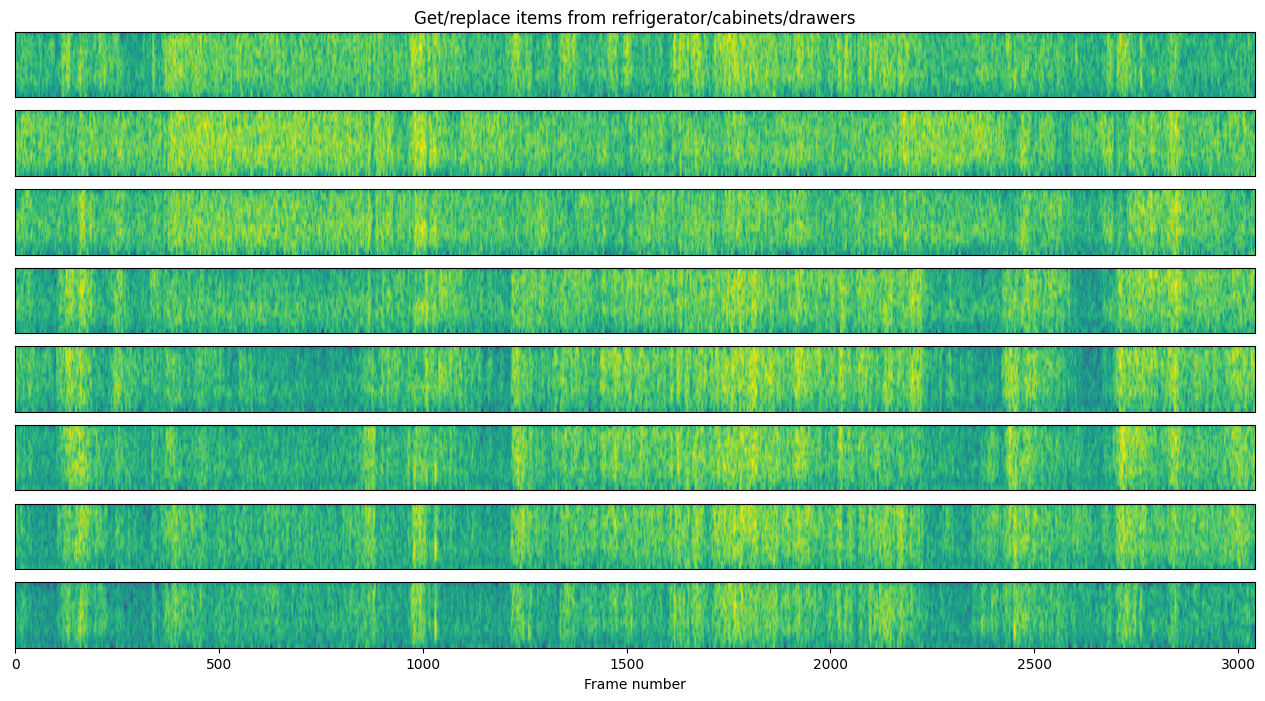

In [ ]:
compute_spectrogram(signal, title)